# Linear Elasticity

In [1]:
import numpy as np
import time
import scipy.sparse.linalg as sp_la
import matplotlib.pyplot as plt
import numba
import os

# Get the number of available CPU cores
num_cores = os.cpu_count()
print(f"This machine has {num_cores} cores.")

# Set Numba to use all of them
numba.set_num_threads(num_cores)
print(f"Numba is set to use {numba.get_num_threads()} threads.")

# --- Core imports ---
from pycutfem.core.mesh import Mesh
from pycutfem.core.dofhandler import DofHandler
from pycutfem.utils.meshgen import structured_quad

# --- UFL-like imports ---
from pycutfem.ufl.functionspace import FunctionSpace
from pycutfem.ufl.expressions import (
    TrialFunction, TestFunction, VectorTrialFunction, VectorTestFunction,
    Function, VectorFunction, Constant, grad, inner, dot, div
)
from pycutfem.ufl.measures import dx, dS
from pycutfem.ufl.forms import BoundaryCondition, assemble_form, Equation
from pycutfem.fem.mixedelement import MixedElement






This machine has 8 cores.
Numba is set to use 8 threads.


In [2]:
# ============================================================================
#    1. PROBLEM SETUP (GEOMETRY, MESH, MATERIAL, LOAD)
# ============================================================================
print("--- Setting up the Cantilever Beam problem ---")

# Beam geometry
L, H = 22.0, 1.0
# Mesh resolution
# NX, NY = 80, 20
NX, NY = 8, 8

# Material properties (e.g., for steel)
E = 1.0e5  # Young's Modulus
nu = 0.3   # Poisson's Ratio

# Applied total shear force on the right boundary (negative for downward)
P_shear = -10.0
# Corresponding traction (force per unit area/length)
traction_val = P_shear / H

# --- Create Mesh ---
# We use quadratic elements (poly_order=2) for better accuracy
nodes, elems, _, corners = structured_quad(L, H, nx=NX, ny=NY, poly_order=2)
mesh = Mesh(nodes=nodes, element_connectivity=elems, elements_corner_nodes=corners, element_type="quad", poly_order=2)

# --- Define and Tag Boundaries ---
bc_tags = {
    'left_wall':  lambda x, y: np.isclose(x, 0),
    'right_wall': lambda x, y: np.isclose(x, L),
}
mesh.tag_boundary_edges(bc_tags)
print(f"Mesh created with {mesh.n_elements} elements.")



# --- Setup MixedElement and DofHandler ---
# We have two fields for 2D displacement: 'ux' and 'uy'
# Both use quadratic basis functions (poly_order=2)
mixed_element = MixedElement(mesh, field_specs={'ux': 2, 'uy': 2})
dof_handler = DofHandler(mixed_element, method='cg')
print(f"DofHandler created with {dof_handler.total_dofs} total DOFs.")

# --- Define Dirichlet Boundary Conditions ---
# The left wall is clamped, so both ux and uy are zero.
dirichlet_bcs = [
    BoundaryCondition('ux', 'dirichlet', 'left_wall', lambda x, y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'left_wall', lambda x, y: 0.0),
]




--- Setting up the Cantilever Beam problem ---
Mesh created with 64 elements.
DofHandler created with 578 total DOFs.


In [3]:
# ============================================================================
#    2. UFL FORMULATION FOR LINEAR ELASTICITY
# ============================================================================
print("\n--- Defining the UFL weak form ---")

# Define vector function spaces for displacement
displacement_space = FunctionSpace("displacement", ['ux', 'uy'])

# Trial and Test functions
u = VectorTrialFunction(displacement_space, dof_handler=dof_handler)
v = VectorTestFunction(displacement_space, dof_handler=dof_handler)

# --- Constitutive Law (Stress-Strain Relationship for Plane Stress) ---
# Strain tensor (symmetric gradient)
def epsilon(vec):
    return 0.5*(grad(vec) + grad(vec).T)

# Identity matrix
I = Constant(np.eye(2))

# Lamé parameters for plane stress
lmbda = Constant(E * nu / (1 - nu**2))
mu = Constant(E / (2 * (1 + nu)))

# Stress tensor
# def sigma(vec):
#     return lmbda * div(vec) * I + 2.0 * mu * epsilon(vec)

# --- Define Bilinear and Linear Forms ---
# Bilinear form (internal virtual work) -> Stiffness Matrix K
a = (lmbda * (div(u) * div(v)) + Constant(2.0)*mu * inner(epsilon(u),epsilon(v))) * dx(metadata={'q':5})

t = Constant(np.asarray([0, traction_val]))
linear_form = dot(t, v) * dS(mesh.edge_bitset("right_wall"),metadata={'q':3})


--- Defining the UFL weak form ---


In [4]:
K,F = assemble_form(Equation(a,linear_form), dof_handler=dof_handler, bcs = dirichlet_bcs, backend='python')
print("Solving the sparse linear system...")
u_sol_vec = sp_la.spsolve(K, F)

Solving the sparse linear system...


In [5]:
# --- Store Solution in a VectorFunction for plotting/analysis ---
solution = VectorFunction(name="Displacement", field_names=['ux', 'uy'], dof_handler=dof_handler)
solution.nodal_values = u_sol_vec

In [6]:
# ============================================================================
# 4. VERIFICATION AND VISUALISATION  (field-aware tip DOF selection)
# ============================================================================

# analytical tip deflection ---------------------------------------------------
I_moment = (1.0 * H**3) / 12.0
analytical_deflection = (P_shear * L**3) / (3 * E * I_moment)

# ---------------------------------------------------------------------------
# Tag the uy-DOF at the free end, first try mid-height, then corner.
# tag_dof_by_locator fills dof_handler.dof_tags[tag] with the matching DOF(s)
# (there is only one in a conforming CG mesh).
# ---------------------------------------------------------------------------
dof_handler.tag_dof_by_locator(
    tag='tip_mid',
    field='uy',
    locator=lambda x, y: np.isclose(x, L) and np.isclose(y, H/2),
    find_first=True
)
if not dof_handler.dof_tags.get('tip_mid'):          # nothing found → fallback
    dof_handler.tag_dof_by_locator(
        tag='tip_corner',
        field='uy',
        locator=lambda x, y: np.isclose(x, L) and np.isclose(y, H),
        find_first=True
    )

# pick whichever tag succeeded
tip_tag = 'tip_mid' if dof_handler.dof_tags.get('tip_mid') else 'tip_corner'
if not dof_handler.dof_tags.get(tip_tag):
    raise RuntimeError("No DOF found on the beam tip – check mesh resolution.")

tip_uy_dof = next(iter(dof_handler.dof_tags[tip_tag]))   # the single global DOF
numerical_deflection = solution.nodal_values[tip_uy_dof]

print(f"Analytical tip deflection (uy): {analytical_deflection:+.6e}")
print(f"Numerical  tip deflection (uy): {numerical_deflection:+.6e}")
print(f"Relative error: "
      f"{abs(numerical_deflection-analytical_deflection)/abs(analytical_deflection):.2%}")




Analytical tip deflection (uy): -4.259200e+00
Numerical  tip deflection (uy): -4.242932e+00
Relative error: 0.38%


Generating displacement field plot …


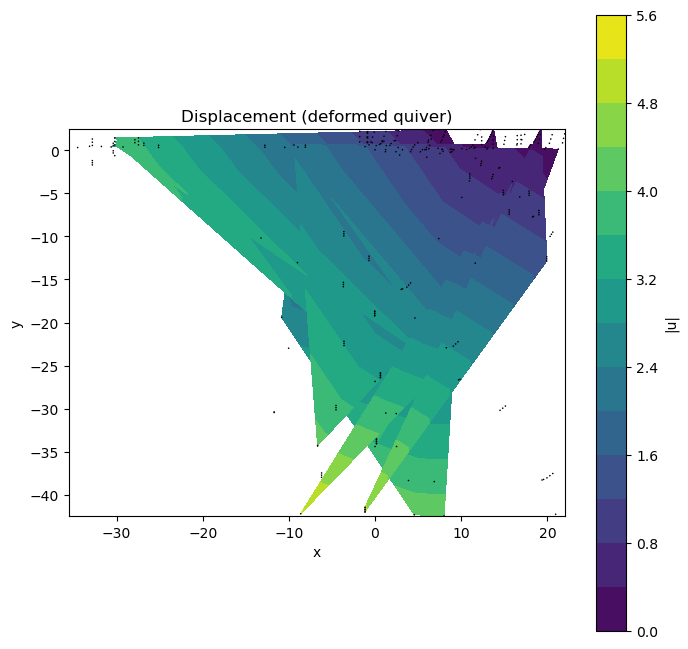

In [7]:
# optional visualisation ------------------------------------------------------
print("Generating displacement field plot …")
solution.plot_deformed(displacement=solution,
                       exaggeration=10.0,
                       kind='quiver',
                       background='magnitude',
                       scale=50)

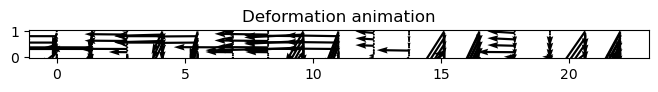

In [8]:
# one-click GIF (requires ImageMagick or Pillow writer)
anim = solution.animate_deformation(solution, exaggeration=10, frames=40)
anim.save("beam_deflection.gif", writer="pillow")